# **Data Analysis & Feature Selection Notebook**

## Objectives

* This notebook will be used to test the dataset for use going forward by performing correlation tests & PPS analysis.

* Our aim is to reduce the number of columns significantly after the feature engineering already performed.  Using the test results from correlation and PPS, we hope to select those features with the greatest meaning for our dataset and prune it down to a lean and meaningful dataset ready for modeling.

## Inputs

* We will use the BitCoinVsMacroNasdaq_v4 dataset saved within outputs/datasets/collection

## Outputs

* Create the train and test datasets from the cleaned and tested dataset

---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/Project5/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/Project5'

---

# Analyse combined dataset

### Load and sort the data

In [60]:
import pandas as pd
df_enriched = pd.read_csv(f"outputs/datasets/collection/BitCoinVsMacroNasdaq_v5.csv")
df_enriched.head()

,Date,Bitcoin_Close,Nasdaq_Close,Gold_Close,Brent_Close,CPI,Ten_Year_Yield,Fed_Funds_Rate,M2_Money_Supply,VIX,Consumer_Sentiment,Real_GDP,Unemployment_Rate,Retail_Sales,Debt_to_GDP
0,2010-07-18,0.0500,2198.229980,1181.699951,75.620003,217.605,2.99,0.18,8639.8,25.97,67.8,16872.266,9.4,347612.0,89.56528
1,2010-07-19,0.0858,2198.229980,1181.699951,75.620003,217.605,2.99,0.18,8639.8,25.97,67.8,16872.266,9.4,347612.0,89.56528
2,2010-07-20,0.0808,2222.489990,1191.500000,76.220001,217.605,2.98,0.18,8639.8,23.93,67.8,16872.266,9.4,347612.0,89.56528
3,2010-07-21,0.0747,2187.330078,1191.599976,75.370003,217.605,2.90,0.18,8639.8,25.64,67.8,16872.266,9.4,347612.0,89.56528
4,2010-07-22,0.0792,2245.889893,1195.500000,77.820000,217.605,2.96,0.18,8639.8,24.63,67.8,16872.266,9.4,347612.0,89.56528


In [61]:
df_enriched["Date"] = pd.to_datetime(df_enriched["Date"])
df_enriched = df_enriched.sort_values("Date")

Check BitCoin price history and distribution

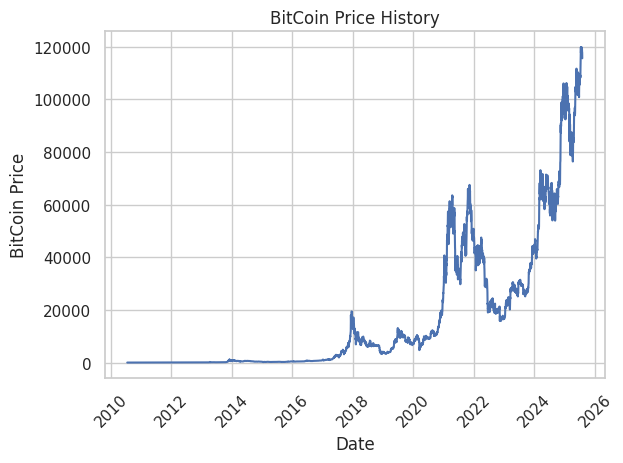

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=df_enriched, x="Date", y="Bitcoin_Close")

plt.title("BitCoin Price History")
plt.xlabel("Date")
plt.ylabel("BitCoin Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


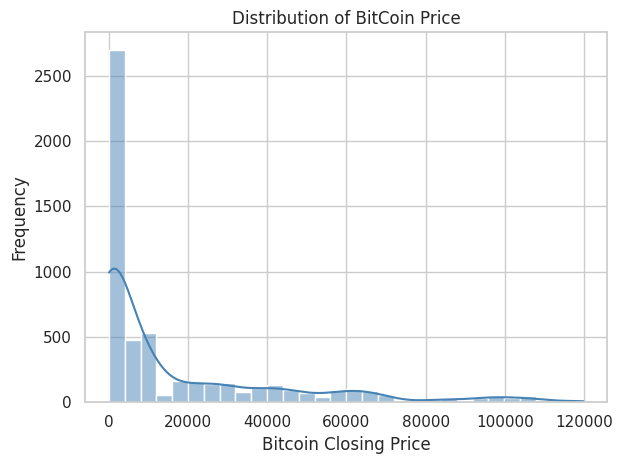

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df_enriched, x="Bitcoin_Close", kde=True, bins=30, color="steelblue")

plt.title("Distribution of BitCoin Price")
plt.xlabel("Bitcoin Closing Price")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


We can see that the price of BitCoin was stable right up to 2017 and then started to gather momentum.  We then see large increases over shorter periods of time.

As a result the distribution of the BitCoin price is not normal and may require transforming.

---

# Perform correlation & PPS review

Here, we will perform a Spearman correlation review, which tells us the monotonic relationship between features i.e. as one increases, the other increases or decreases, but not necessarily at the same rate.

In [8]:
corr_spearman = df_enriched.corr(method='spearman', numeric_only=True)['Bitcoin_Close'].drop('Bitcoin_Close').apply(abs).sort_values(ascending=False)
corr_spearman

Nasdaq_Close          0.979650
CPI                   0.970699
Retail_Sales          0.964372
Real_GDP              0.963363
M2_Money_Supply       0.961354
Debt_to_GDP           0.915886
Unemployment_Rate     0.679118
Gold_Close            0.613852
Fed_Funds_Rate        0.473553
Ten_Year_Yield        0.257468
Brent_Close           0.254973
Consumer_Sentiment    0.215752
VIX                   0.070919
Name: Bitcoin_Close, dtype: float64

We can see a number of highly correlated absolute features in the dataset.  Many of which are above 90%.

We will now perform a Pearson correlation test, which measures the linear relationship between features i.e. each increase in one feature causes a fixed or proportional change in another

In [9]:
corr_pearson = df_enriched.corr(method='pearson', numeric_only=True)['Bitcoin_Close'].drop('Bitcoin_Close').apply(abs).sort_values(ascending=False)
corr_pearson

Nasdaq_Close          0.915067
Gold_Close            0.885899
CPI                   0.850711
Retail_Sales          0.841639
Real_GDP              0.808054
M2_Money_Supply       0.793514
Debt_to_GDP           0.719441
Fed_Funds_Rate        0.633266
Ten_Year_Yield        0.508819
Consumer_Sentiment    0.468182
Unemployment_Rate     0.381728
VIX                   0.063427
Brent_Close           0.055733
Name: Bitcoin_Close, dtype: float64

Again, the results show a number of highly correlated features, but lesser than those captured under Spearman.

Finally, we will calculate the Predictive Power Score (PPS).  It tells us how well one feature can predict another feature.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps

def CalculatePPS(df):
    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return pps_matrix

In [11]:
pps_matrix = CalculatePPS(df_enriched)

/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dt

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min    25%    50%    75%  max
ppscore  210.0  0.637  0.321  0.0  0.446  0.696  0.927  1.0


/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)


We see that out of 210 evaluations, features have a strong PPS (.637) and high variability (0.321).  The top quartile has some strong predictive power.  

Below, we will review each feature's PPS score.

In [12]:
import pandas as pd
pd.set_option('display.max_rows', None)

pps_scores = pps_matrix.loc['Bitcoin_Close'].sort_values(ascending=False)
pps_scores_df = pps_scores.reset_index()
pps_scores_df.columns = ['Feature', 'PPS']

pps_scores_df

,Feature,PPS
0,Bitcoin_Close,1.000000
1,Date,0.976448
2,Retail_Sales,0.940829
3,CPI,0.940470
4,M2_Money_Supply,0.919821
5,Real_GDP,0.877292
6,Nasdaq_Close,0.875495
7,Debt_to_GDP,0.875433
8,Consumer_Sentiment,0.805108
9,Gold_Close,0.691056


We will also visualise this with the below graph, and as expected, there is a jump to 0.8 and above up in the upper quartile.

<Axes: >

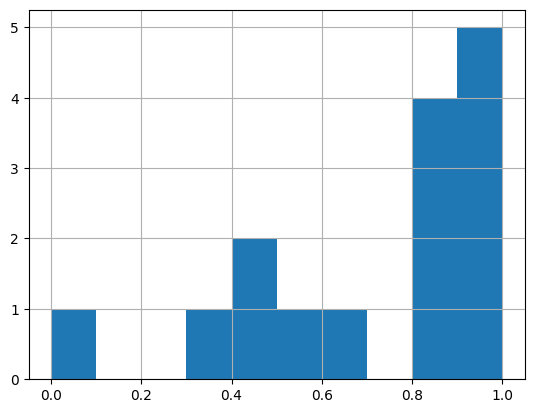

In [13]:
pps_scores_df['PPS'].hist(bins=10)

What we'll do next is to trim the dataset based on a threshold of 0.6 for all three tests - Spearman, Pearson and PPS.

We will then get the average of the 3 tests and display it in a "Signal" column.  

We can see that the features have been cut to 7.

In [14]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


corr_spearman_df = corr_spearman.reset_index()
corr_spearman_df.columns = ['Feature', 'Spearman']

corr_pearson_df = corr_pearson.reset_index()
corr_pearson_df.columns = ['Feature', 'Pearson']

feature_scores = pps_scores_df.merge(corr_pearson_df, on='Feature').merge(corr_spearman_df, on='Feature')

filtered_features = feature_scores[
    (feature_scores['PPS'] > 0.6) &
    (feature_scores['Pearson'] > 0.6) &
    (feature_scores['Spearman'] > 0.6)
]

filtered_features = filtered_features.copy()

filtered_features['Signal'] = filtered_features[['PPS', 'Pearson', 'Spearman']].mean(axis=1)
filtered_features = filtered_features.sort_values('Signal', ascending=False)

filtered_features


,Feature,PPS,Pearson,Spearman,Signal
4,Nasdaq_Close,0.875495,0.915067,0.979650,0.923404
1,CPI,0.940470,0.850711,0.970699,0.920627
0,Retail_Sales,0.940829,0.841639,0.964372,0.915613
2,M2_Money_Supply,0.919821,0.793514,0.961354,0.891563
3,Real_GDP,0.877292,0.808054,0.963363,0.882903
5,Debt_to_GDP,0.875433,0.719441,0.915886,0.836920
7,Gold_Close,0.691056,0.885899,0.613852,0.730269


The below code will simply reorder the columns to reflect Date and Bitcoin_close first and select the top 5 features per the filtered features table.

In [15]:
filtered_features = filtered_features[~filtered_features['Feature'].isin(['Date', 'Bitcoin_Close'])]

top_5_features = filtered_features.sort_values('Signal', ascending=False).head(5)['Feature'].tolist()

ordered_columns = ['Date', 'Bitcoin_Close'] + top_5_features

df_final = df_enriched[ordered_columns].sort_values('Date').reset_index(drop=True)

df_final.head()

,Date,Bitcoin_Close,Nasdaq_Close,CPI,Retail_Sales,M2_Money_Supply,Real_GDP
0,2010-07-18,0.0500,2198.229980,217.605,347612.0,8639.8,16872.266
1,2010-07-19,0.0858,2198.229980,217.605,347612.0,8639.8,16872.266
2,2010-07-20,0.0808,2222.489990,217.605,347612.0,8639.8,16872.266
3,2010-07-21,0.0747,2187.330078,217.605,347612.0,8639.8,16872.266
4,2010-07-22,0.0792,2245.889893,217.605,347612.0,8639.8,16872.266


At this point, we'll save the dataset before splitting it into Train and Test files.

In [17]:
import os
try:
  os.makedirs(name='outputs/datasets/final_features')
except Exception as e:
  print(e)

df_final.to_csv(f"outputs/datasets/final_features/BtcFinalFeatures.csv",index=False)

[Errno 17] File exists: 'outputs/datasets/final_features'


## Correlation & PPS Summary:

* Correlation Tests and PPS were used together to filter all three scores > 0.6 and this left us with 7 features.
* Signal score was introduced for each of the remaining features creating a power ranking of each feature.
* On the 7 remaining features, we reduced further to 5.
* We were left with a lean dataset of non-redundant features.
* The dataset is chronologically sorted with high signal and low noise.


---

We will also save the BitCoin price history & BitCoin distribution graphs from above.

In [38]:
import os
try:
  os.makedirs(name='outputs/datasets/figs')
except Exception as e:
  print(e)


[Errno 17] File exists: 'outputs/datasets/figs'


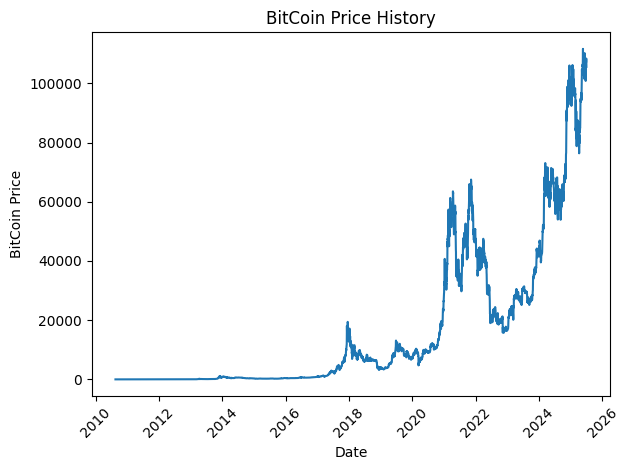

<Figure size 640x480 with 0 Axes>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=df_feat_eng, x="Date", y="Bitcoin_Close")

plt.title("BitCoin Price History")
plt.xlabel("Date")
plt.ylabel("BitCoin Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.savefig("outputs/datasets/figs/bitcoin_price_history.png", dpi=300)

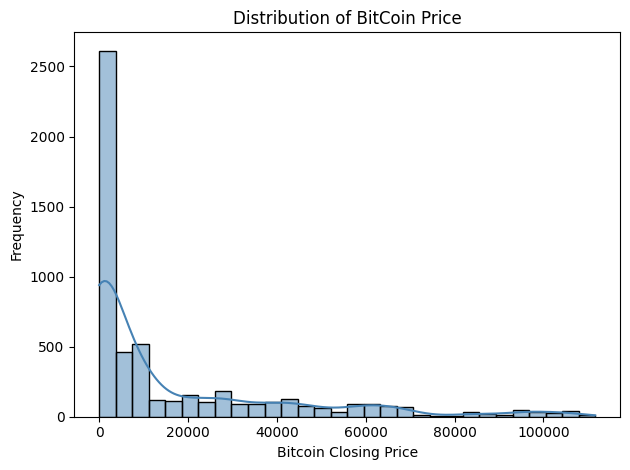

<Figure size 640x480 with 0 Axes>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df_feat_eng, x="Bitcoin_Close", kde=True, bins=30, color="steelblue")

plt.title("Distribution of BitCoin Price")
plt.xlabel("Bitcoin Closing Price")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.savefig("outputs/datasets/figs/bitcoin_distribution.png", dpi=300)